In [1]:
import ray
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange,ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed

from gym.spaces import Discrete
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair, Instrument
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer

import ray.rllib.agents.ppo as ppo

### Renderer (Plot)

In [2]:
class PositionChangeChart(Renderer):
    """The Renderer renders a view of the environment and interactions."""
    
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        # The Observer generates the next observation for the agent.
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="v", color="red") # BUY
        axs[0].scatter(sell.index, sell.values, marker="^", color="green") # SELL
        axs[0].set_title("Trading Chart")
        axs[0].legend(['Price', 'Buys', 'Sells'])

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

---

### DRL Model

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [28]:
def generate_train_test_datasets(ticker, train_test_split):
    """Get Yahoo! Finance Data for Train/Test Splits."""

    yf_ticker = yf.Ticker(ticker=f'{ticker}.SA')

    df = yf_ticker.history(period='1y', interval='1h')
    df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    df["Volume"] = df["Volume"].fillna(0).astype(int)
    df.ta.log_return(append=True, length=16)
    df.ta.rsi(append=True, length=14)
    df.ta.macd(append=True, fast=12, slow=26)
    df.dropna(inplace=True)

    next_day = datetime.strptime(train_test_split, '%Y-%m-%d')
    next_day = next_day + timedelta(days=1)
    next_day = next_day.strftime('%Y-%m-%d')

    df_training = df.loc[:train_test_split].copy()
    df_evaluation = df.loc[next_day:].copy()

    df_training = df_training.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    df_evaluation = df_evaluation.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})

    df_training.dropna().to_csv('../../data/testing/training.csv', index=True)
    df_evaluation.dropna().to_csv('../../data/testing/evaluation.csv', index=True)

    return df_training, df_evaluation

In [29]:
df_train, df_test = generate_train_test_datasets('PETR4', '2021-08-27')

In [30]:
df_train.tail()

,open,high,low,close,volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2021-08-27 12:00:00-03:00,28.040001,28.160000,27.980000,28.150000,12030400,0.022998,67.699115,0.183076,0.027274,0.155802
2021-08-27 13:00:00-03:00,28.150000,28.280001,28.100000,28.270000,7911400,0.026162,69.964186,0.208712,0.042328,0.166384
2021-08-27 14:00:00-03:00,28.280001,28.280001,28.150000,28.230000,4817600,0.026199,68.246213,0.223227,0.045475,0.177752
2021-08-27 15:00:00-03:00,28.230000,28.350000,28.180000,28.320000,9474100,0.030110,70.029389,0.239235,0.049186,0.190049
2021-08-27 16:00:00-03:00,28.309999,28.490000,28.299999,28.459999,9437800,0.032860,72.606394,0.260219,0.056136,0.204083


In [31]:
df_test.head()

,open,high,low,close,volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2021-08-30 10:00:00-03:00,28.400000,28.650000,28.260000,28.360001,0,0.019225,68.102047,0.265717,0.049307,0.216410
2021-08-30 11:00:00-03:00,28.360001,28.639999,28.309999,28.600000,17729600,0.032697,72.509973,0.286141,0.055785,0.230356
2021-08-30 12:00:00-03:00,28.600000,28.709999,28.520000,28.549999,6784500,0.025902,70.329441,0.294894,0.051630,0.243264
2021-08-30 13:00:00-03:00,28.540001,28.620001,28.510000,28.570000,4177000,0.030203,70.708883,0.299986,0.045378,0.254608
2021-08-30 14:00:00-03:00,28.570000,28.590000,28.340000,28.350000,6541200,0.021031,61.406393,0.283007,0.022719,0.260288


---

In [7]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    # 1. Data and TensorTrade Objects

    ticker = 'PETR4'
    
    dataset = pd.read_csv(filepath_or_buffer="../../data/testing/training.csv", 
                          parse_dates=True).fillna(method='backfill').fillna(method='ffill')
    
    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    feed = DataFeed(features)
    feed.compile()
    
    # 2. Rewards

    # Rewards - Risk Adjusted
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # 3. Actions

    # action_scheme = default.actions.ManagedRiskOrders(
    #     stop=[0.05],
    #     take=[0.075],
    #     min_order_pct=0.5
    # )

    # A discrete action scheme that determines actions based on managing risk
    action_scheme = default.actions.ManagedRiskOrders()

    # 4. Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset.index)).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume"),
        Stream.sensor(action_scheme.broker, lambda b: len(b.unexecuted), dtype="float").rename("action")
    ])

    # 5. Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [8]:
window_size = 35

env_config_training = {
    # We want to look at the last 14 samples (hours)
    "window_size": window_size, # hours * days
    # And calculate reward based on the actions taken in the next 7 hours
    #"reward_window_size": 7,
    # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "max_allowed_loss": 0.10,
}

analysis = tune.run(
    # We'll be using the builtin PPO agent in RLLib
    run_or_experiment="PPO",
    name="MyExperiment1",
    metric='episode_reward_mean',
    stop={
      "episode_reward_mean": 0.05
    },
    config={
        "env": "TradingEnv",
        "env_config": env_config_training,
        "log_level": "DEBUG",
        "framework": "tf2",
        "eager_tracing": True,
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2022-04-26 16:43:47,001	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc
PPO_TradingEnv_36179_00000,PENDING,


2022-04-26 16:43:57,234	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=1600) 2022-04-26 16:44:02,399	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=True. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=17184) 2022-04-26 16:44:07,636	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=17184) 2022-04-26 16:44:07,698	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=17184) 2022-04-26 16:44:07,708	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000002196D39EA90>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17184)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17184)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17184)  [-inf -inf -inf -inf -

Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


 pid=1600) 2022-04-26 16:44:11,343	INFO rollout_worker.py:1555 -- Built policy map: {}
 pid=1600) 2022-04-26 16:44:11,343	INFO rollout_worker.py:1556 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000015F07BE0610>}
 pid=1600) 2022-04-26 16:44:11,344	INFO rollout_worker.py:618 -- Built filter map: {'default_policy': MeanStdFilter((35, 10), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
 pid=1600) 2022-04-26 16:44:11,344	DEBUG rollout_worker.py:728 -- Created rollout worker with env None (None), policies {}
 pid=1600) 2022-04-26 16:44:11,353	WARNING util.py:57 -- Install gputil for GPU system monitoring.
 pid=17184) 2022-04-26 16:44:12,195	INFO rollout_worker.py:754 -- Generating sample batch of size 200
 pid=17184) 2022-04-26 16:44:12,195	DEBUG sampler.py:568 -- No episode horizon specified, assuming inf.
 pid=17184) 2022-04-26 16:44:12,197	INFO sampler.py:624 -- Raw obs from env: { 0:

Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


 pid=17184) 2022-04-26 16:44:12,571	INFO sampler.py:1076 -- Outputs of compute_actions():
 pid=17184) tWorker
 pid=17184) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=159.0, max=159.0, mean=159.0),
 pid=17184)                       [],
 pid=17184)                       { 'action_dist_inputs': np.ndarray((1, 181), dtype=float32, min=0.0, max=0.0, mean=0.0),
 pid=17184)                         'action_logp': np.ndarray((1,), dtype=float32, min=-5.198, max=-5.198, mean=-5.198),
 pid=17184)                         'action_prob': np.ndarray((1,), dtype=float32, min=0.006, max=0.006, mean=0.006),
 pid=17184)                         'vf_preds': np.ndarray((1,), dtype=float32, min=0.0, max=0.0, mean=0.0)})}
 pid=17184) tWorker
 pid=17184) 2022-04-26 16:44:13,459	INFO simple_list_collector.py:781 -- Trajectory fragment after postprocess_trajectory():
 pid=17184) tWorker
 pid=17184) { 'agent0': { 'action_dist_inputs': np.ndarray((200, 181), dtype=float32, min=-0.02, max=0.021, mean=-0

Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


 pid=1600) 2022-04-26 16:44:35,549	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=1600) 2022-04-26 16:44:35,549	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
 pid=1600) 2022-04-26 16:44:35,550	INFO rollout_worker.py:836 -- Training on concatenated sample batches:
 pid=1600) 
 pid=1600) { 'count': 128,
 pid=1600)   'policy_batches': { 'default_policy': { 'action_dist_inputs': np.ndarray((128, 181), dtype=float32, min=-0.021, max=0.03, mean=0.0),
 pid=1600)                                           'action_logp': np.ndarray((128,), dtype=float32, min=-5.209, max=-5.181, mean=-5.198),
 pid=1600)                                           'actions': np.ndarray((128,), dtype=int64, min=1.0, max=180.0, mean=95.523),
 pid=1600)                                           'advantages': np.ndarray((12

Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


 pid=1600) 2022-04-26 16:44:37,767	DEBUG rollout_worker.py:865 -- Training out:
 pid=1600) 
 pid=1600) { 'default_policy': { 'custom_metrics': {},
 pid=1600)                       'learner_stats': { 'cur_kl_coeff': 0.20000000298023224,
 pid=1600)                                          'cur_lr': 0.10000000149011612,
 pid=1600)                                          'entropy': 5.198487,
 pid=1600)                                          'entropy_coeff': 0.009999999776482582,
 pid=1600)                                          'kl': -3.1282195e-09,
 pid=1600)                                          'policy_loss': -0.022361709,
 pid=1600)                                          'total_loss': 0.40609515,
 pid=1600)                                          'vf_explained_var': 5.4478645e-05,
 pid=1600)                                          'vf_loss': 0.96088344}}}
 pid=1600) 


Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


Trial name,status,loc
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600


Result for PPO_TradingEnv_36179_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-26_16-44-51
  done: true
  episode_len_mean: 555.0
  episode_media: {}
  episode_reward_max: 0.10123990600481647
  episode_reward_mean: 0.05734827217862705
  episode_reward_min: -0.014776356987128758
  episodes_this_iter: 7
  episodes_total: 7
  experiment_id: a0bebc79963642719e5e07e35d47424a
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.10000000149011612
          entropy: 5.197668075561523
          entropy_coeff: 0.009999999776482582
          kl: 0.0008165508625097573
          policy_loss: -0.0187168437987566
          total_loss: 0.40080055594444275
          vf_explained_var: 0.017511311918497086
          vf_loss: 0.9426615238189697
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_sin

 pid=1600) 2022-04-26 16:44:51,722	DEBUG trainer.py:1741 -- synchronized filters: {'default_policy': MeanStdFilter((35, 10), True, True, None, (n=4008, mean_mean=718820.1182088491, mean_std=568617.3341839318), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36179_00000,RUNNING,127.0.0.1:1600,1,40.359,4000,0.0573483,0.10124,-0.0147764,555


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_36179_00000,TERMINATED,127.0.0.1:1600,1,40.359,4000,0.0573483,0.10124,-0.0147764,555


2022-04-26 16:44:54,875	INFO tune.py:626 -- Total run time: 57.90 seconds (57.21 seconds for the tuning loop).


---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [9]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)

checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": env_config_training,
        "log_level": "DEBUG",
        "framework": "tf2",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "model": {
            "fcnet_hiddens": [256, 256], # Hyperparameter grid search defined above
        },
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
)

2022-04-26 16:44:54,990	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=17336) 2022-04-26 16:45:00,240	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=17336) 2022-04-26 16:45:00,286	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=17336) 2022-04-26 16:45:00,297	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000025B9274FB80>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17336)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17336)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17336)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=17336)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pi

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

2022-04-26 16:45:06,246	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: C:\Users\mathe\ray_results\MyExperiment1\PPO_TradingEnv_36179_00000_0_2022-04-26_16-43-57\checkpoint_000001\checkpoint-1
2022-04-26 16:45:06,247	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': 0, '_time_total': 40.359046936035156, '_episodes_total': 7}


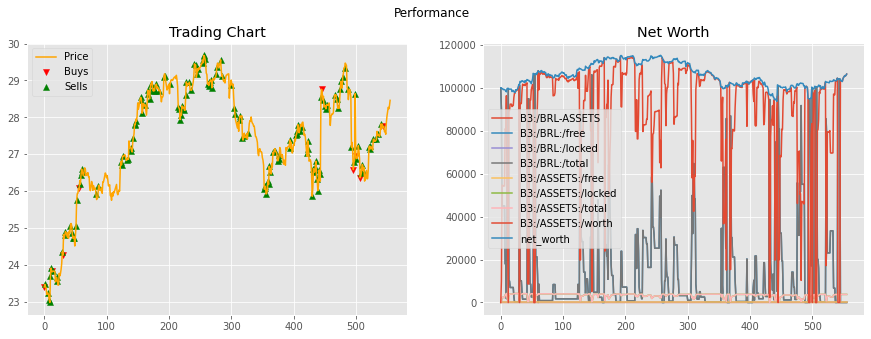

In [10]:
# Restore agent
agent.restore(checkpoint_path)

# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

---

### Validation Set

In [32]:
def create_eval_env(config):
    """Creates the Evaluation Environment."""
    dataset = pd.read_csv(filepath_or_buffer="../../data/testing/evaluation.csv", 
                          parse_dates=True).fillna(method='backfill').fillna(method='ffill')

    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    feed = DataFeed(features)
    feed.compile()
    
    # Rewards - Risk Adjusted
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # Actions
    # action_scheme = default.actions.ManagedRiskOrders(
    #     stop=[0.05],
    #     take=[0.075],
    #     min_order_pct=0.5
    # )

    # A discrete action scheme that determines actions based on managing risk
    action_scheme = default.actions.ManagedRiskOrders()
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset.index)).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        #renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment, portfolio

In [33]:
# 1. Instantiate the evaluation environment
env, portfolio = create_eval_env({
    "window_size": window_size
})

# 2. Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

open
high
low
close
volume
LOGRET_16
RSI_14
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,f4313958-f147-4f27-b5d8-e56784fe6cf9,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),10000.00 BRL,90000.00 BRL,10000.00 BRL,10000.00 BRL
1,f4313958-f147-4f27-b5d8-e56784fe6cf9,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),35.00 BRL,90000.00 BRL,9965.00 BRL,9965.00 BRL
2,f4313958-f147-4f27-b5d8-e56784fe6cf9,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),9965.00 BRL,90000.00 BRL,0.00 BRL,0.00 BRL
3,f4313958-f147-4f27-b5d8-e56784fe6cf9,2,B3,B3:ASSETS/locked,DEPOSIT (TRADED 9965.00 BRL B3:BRL/ASSETS @ 28...,348.43 ASSETS,0.00 ASSETS,348.43 ASSETS,348.43 ASSETS
4,936c5832-4345-4173-9455-47325b8c4c15,3,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),9000.00 BRL,81000.00 BRL,9000.00 BRL,9000.00 BRL
5,936c5832-4345-4173-9455-47325b8c4c15,3,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),31.50 BRL,81000.00 BRL,8968.50 BRL,8968.50 BRL
6,936c5832-4345-4173-9455-47325b8c4c15,3,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),8968.50 BRL,81000.00 BRL,0.00 BRL,0.00 BRL
7,936c5832-4345-4173-9455-47325b8c4c15,3,B3,B3:ASSETS/locked,DEPOSIT (TRADED 8968.50 BRL B3:BRL/ASSETS @ 28...,314.13 ASSETS,0.00 ASSETS,662.56 ASSETS,314.13 ASSETS
8,f48c980d-ec6d-48c5-ada4-806f43a82921,4,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),64800.00 BRL,16200.00 BRL,64800.00 BRL,64800.00 BRL
9,f48c980d-ec6d-48c5-ada4-806f43a82921,4,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),226.80 BRL,16200.00 BRL,64573.20 BRL,64573.20 BRL


In [ ]:
portfolio.ledger.as_frame().head(10)

In [14]:
df = pd.DataFrame(portfolio.performance)

<AxesSubplot:>

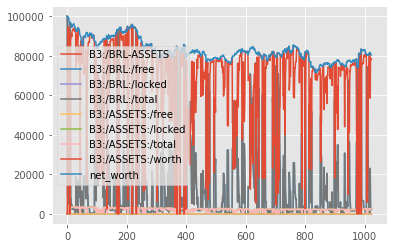

In [15]:
df.T.plot()

<AxesSubplot:>

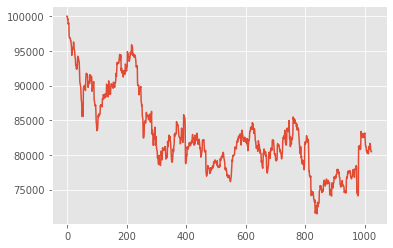

In [16]:
df.loc["net_worth"].plot()

<AxesSubplot:>

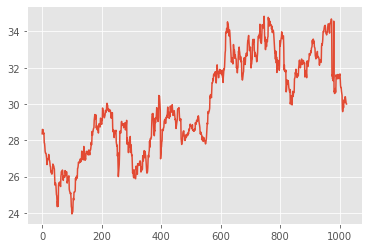

In [17]:
df.loc["B3:/BRL-ASSETS"].plot()

<AxesSubplot:>

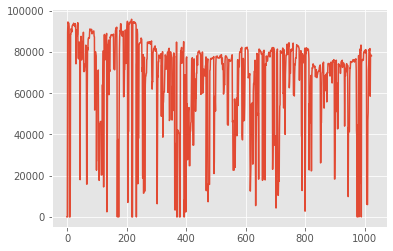

In [18]:
df.loc["B3:/ASSETS:/worth"].plot()

In [19]:
worth_streams = []
for wallet in portfolio.wallets:
    total_balance = Stream.sensor(
        wallet,
        lambda w: w.total_balance.as_float(),
        dtype="float"
    )
    
    symbol = wallet.instrument.symbol

    if symbol == portfolio.base_instrument.symbol:
        worth_streams += [total_balance]
    else:
        price = Stream.select(
        wallet.exchange.streams(),
            lambda s: s.name.endswith(symbol)
        )
        worth_streams += [(price * total_balance)]

net_worth = Stream.reduce(worth_streams).sum().rename("net_worth")

In [20]:
net_worth

---